In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

file_icon = "/home/qwertz/data_js_icon_22_23_August_2018/stat_IQQ_all-times.nc"
ds_icon = xr.open_dataset(file_icon)


print(ds_icon.data_vars)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Data variables:
    clon_bnds      (ncells, vertices) float32 12B ...
    clat_bnds      (ncells, vertices) float32 12B ...
    height_bnds    (height, bnds) float64 3kB ...
    height_3_bnds  (height_3, bnds) float64 3kB ...
    qv             (time, height, ncells) float32 250kB ...
    qc             (time, height, ncells) float32 250kB ...
    qi             (time, height, ncells) float32 250kB ...
    qr             (time, height, ncells) float32 250kB ...
    qs             (time, height, ncells) float32 250kB ...
    qg             (time, height, ncells) float32 250kB ...
    qh             (time, height, ncells) float32 250kB ...
    qnc            (time, height, ncells) float32 250kB ...
    qni            (time, height, ncells) float32 250kB ...
    qnr            (time, height, ncells) float32 250kB ...
    qns            (time, height, ncells) float32 250kB ...
    qng            (time, height, ncells) float32 250kB ...
    qnh            (time, height, ncells) float32 250k

Mittlere Divergenz in ICON data:  -3.0712705e-05


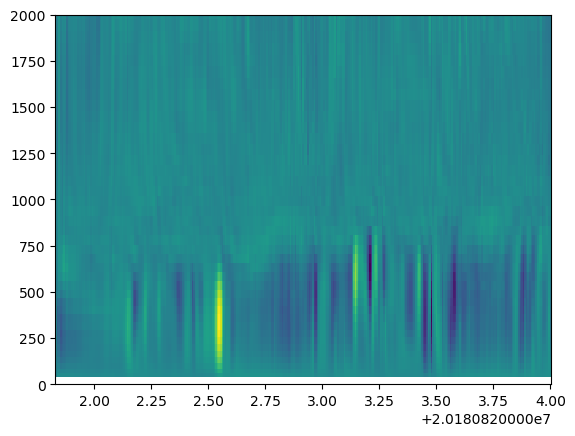

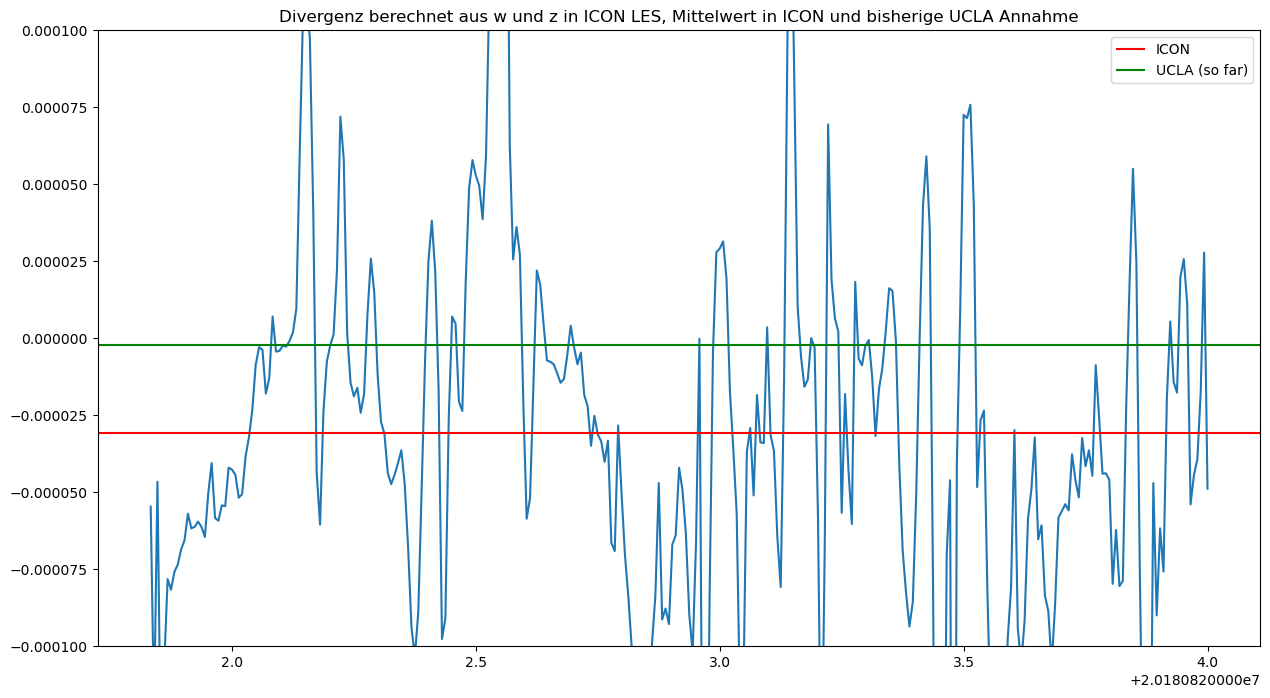

In [14]:
# Get vertical wind array by time - nur für unterste 2700 m kalkuliert:
# w              (time, height_2, ncells) float32 252kB ...

mean_ws = ds_icon["w"].isel(ncells=0).mean("time")
ws_by_time = ds_icon["w"].isel(ncells=0).values[:,150:]

plt.pcolormesh(ds_icon["time"], ds_icon["z_ifc"].values[151:], ws_by_time[:,:-1].T)
plt.ylim(0,2000)

# Mean divergence:
ws_for_div = mean_ws.values[150:]
z_for_div = ds_icon["z_ifc"].isel(ncells=0).values[150:]
mean_div_by_height = ws_for_div/z_for_div
mean_div_ICON = np.nanmean(mean_div_by_height)
print("Mittlere Divergenz in ICON data: ", mean_div_ICON)

# Divergence by time:
divergenz_by_height_and_time = ws_by_time/z_for_div
div_by_time = np.nanmean(divergenz_by_height_and_time, axis=1)
plt.figure(figsize=(15,8))
plt.title("Divergenz berechnet aus w und z in ICON LES, Mittelwert in ICON und bisherige UCLA Annahme")
plt.plot(ds_icon["time"], div_by_time)
plt.ylim(-0.0001, 0.0001)
plt.axhline(mean_div_ICON, color="red", label="ICON")
plt.axhline(-2.266e-6, color="green", label="UCLA (so far)")
plt.legend()


###########################################
# Mache den 2. Plot schön und vorzeigbar mit ordentlicher Zeitachse.
# Gibt es sowas wie einen Tagesgang in der Divergenz?

In [4]:
# Measurement divergence
# Observation wind vector from wind lidar:

import subprocess

#########################################################

def convert_julian_to_datetime(julian_array):
    # Konvertiere den Julian-Tag in Unix-Zeitstempel
    unix_times = (julian_array - 2440587.5) * 86400
    
    # Konvertiere Unix-Zeitstempel in Datumszeichenfolgen im ISO-Format
    date_strings = []
    for unix_time in unix_times:
        command = f"date -ud '@{int(unix_time)}' +'%Y-%m-%d %H:%M:%S'"
        result = subprocess.run(command, shell=True, capture_output=True, text=True)
        if result.returncode == 0:
            date_strings.append(result.stdout.strip())
        else:
            raise ValueError("Fehler beim Konvertieren des Unix-Zeitstempels.")
    
    # Konvertiere Datumszeichenfolgen in np.datetime64-Objekte
    datetime_array = np.array(date_strings, dtype='datetime64')
    
    return datetime_array

##############################################################

file_wind22 = "/home/qwertz/obs_data_MA/iqq_lidar_halo/22/wind_vad-24_20180822.nc"
file_wind23 = "/home/qwertz/obs_data_MA/iqq_lidar_halo/23/wind_vad-24_20180823.nc"
ds_wind = xr.open_mfdataset([file_wind22, file_wind23])# # t Kelvin / less timesteps...
# ds_foghat_reduced4 = ds_theta_v4.sel(time=slice(datetime_begin, datetime_end)).mean("time")
datetime_array = convert_julian_to_datetime(ds_wind["time"].values)
ds_wind = ds_wind.assign_coords(time=("time", datetime_array))


/tmp/ipykernel_63849/601133038.py:33: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds_wind = ds_wind.assign_coords(time=("time", datetime_array))


[  15.   45.   75.  105.  135.  165.  195.  225.  255.  285.  315.  345.
  375.  405.  435.  465.  495.  525.  555.  585.  615.  645.  675.  705.
  735.  765.  795.  825.  855.  885.  915.  945.  975. 1005. 1035. 1065.
 1095. 1125. 1155. 1185. 1215. 1245. 1275. 1305. 1335. 1365. 1395. 1425.
 1455. 1485. 1515. 1545. 1575. 1605. 1635. 1665. 1695. 1725. 1755. 1785.
 1815. 1845. 1875. 1905. 1935. 1965. 1995. 2025. 2055. 2085. 2115. 2145.
 2175. 2205. 2235. 2265. 2295. 2325. 2355. 2385.]
Mittlere Divergenz in Lidar Wind data:  -0.00019285016


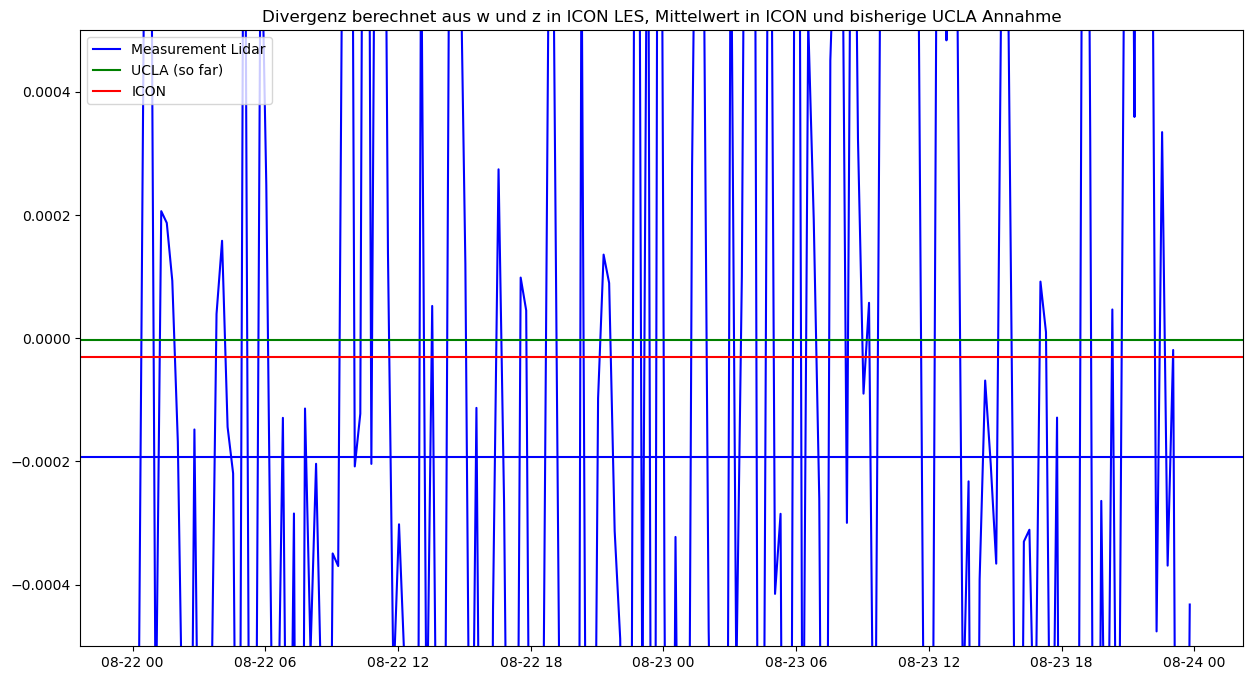

In [16]:
# Calculate divergence for Lidar wind:

zs = ds_wind["height"]
time = ds_wind["time"]
ws_mean = ds_wind["wind_vec"].mean("time").values[2,:]
ws_by_time = ds_wind["wind_vec"].values[2,:,:]

print(zs.values[:80])

# Mean divergence:
ws_for_div = ws_mean[:80]
z_for_div = zs.values[:80]
mean_div_by_height = ws_for_div/z_for_div
mean_div = np.nanmean(mean_div_by_height)
print("Mittlere Divergenz in Lidar Wind data: ", mean_div)


# Divergence by time:
divergenz_by_height_and_time = ws_by_time[:80,:].T / z_for_div
div_by_time_meas = np.nanmean(divergenz_by_height_and_time, axis=1)
plt.figure(figsize=(15,8))
plt.title("Divergenz berechnet aus w und z in ICON LES, Mittelwert in ICON und bisherige UCLA Annahme")
plt.plot(ds_wind["time"], div_by_time_meas, color="blue", linestyle="-")
# plt.plot(ds_icon["time"], div_by_time, color="red", linestyle="-")
plt.ylim(-0.0005, 0.0005)
plt.axhline(mean_div, color="blue", label="Measurement Lidar")
plt.axhline(-2.266e-6, color="green", label="UCLA (so far)")
plt.axhline(mean_div_ICON, color="red", label="ICON")
plt.legend()

########################################
# You could convert ICON time to numpy 64, to make this plot visible with all its parts...
# Obs: -1.9285 e-4
# UCLA: -2.266e-6
# ICON: 3.0713e-05

# => Subsidence / Divergence is very strong in observations and has to be much weaker in UCLA to keep up zi
# => In reality Entrainment counteracting Subsidence must be much stronger, than it appears in models!
# Es wäre aber bessser Daten für w von oberhalb von zi einzubeziehen...

Mean divergence at 1000 m:  -4.069406636894517e-05
For other heights: 
Mean divergence at  0   500  m:  1.0725545428862306e-05
Mean divergence at  1   550  m:  6.9696407446681105e-06
Mean divergence at  2   600  m:  4.561577554891958e-06
Mean divergence at  3   650  m:  1.170482365416182e-06
Mean divergence at  4   700  m:  5.648159803940025e-07
Mean divergence at  5   750  m:  4.680550426496736e-06
Mean divergence at  6   775  m:  5.5447615489595965e-06
Mean divergence at  7   800  m:  9.53972203277074e-06
Mean divergence at  8   825  m:  1.779770018903561e-05
Mean divergence at  9   850  m:  3.524611839520246e-05
Mean divergence at  10   875  m:  4.2600201444407113e-05
Mean divergence at  11   900  m:  4.8086842341721534e-05
Mean divergence at  12   925  m:  5.2785197629652854e-05
Mean divergence at  13   950  m:  4.168533778142923e-05
Mean divergence at  14   975  m:  9.772516527000595e-07
Mean divergence at  15   1000  m:  -4.069406636894517e-05


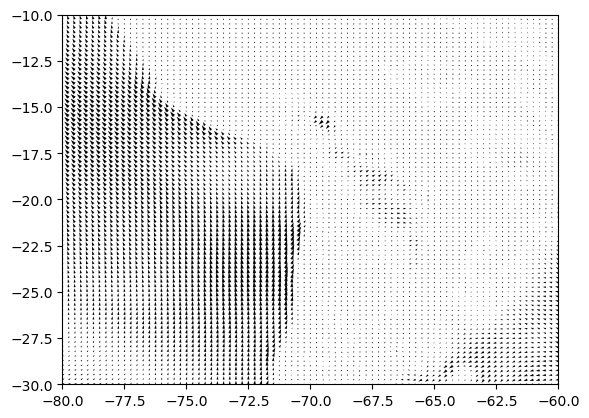

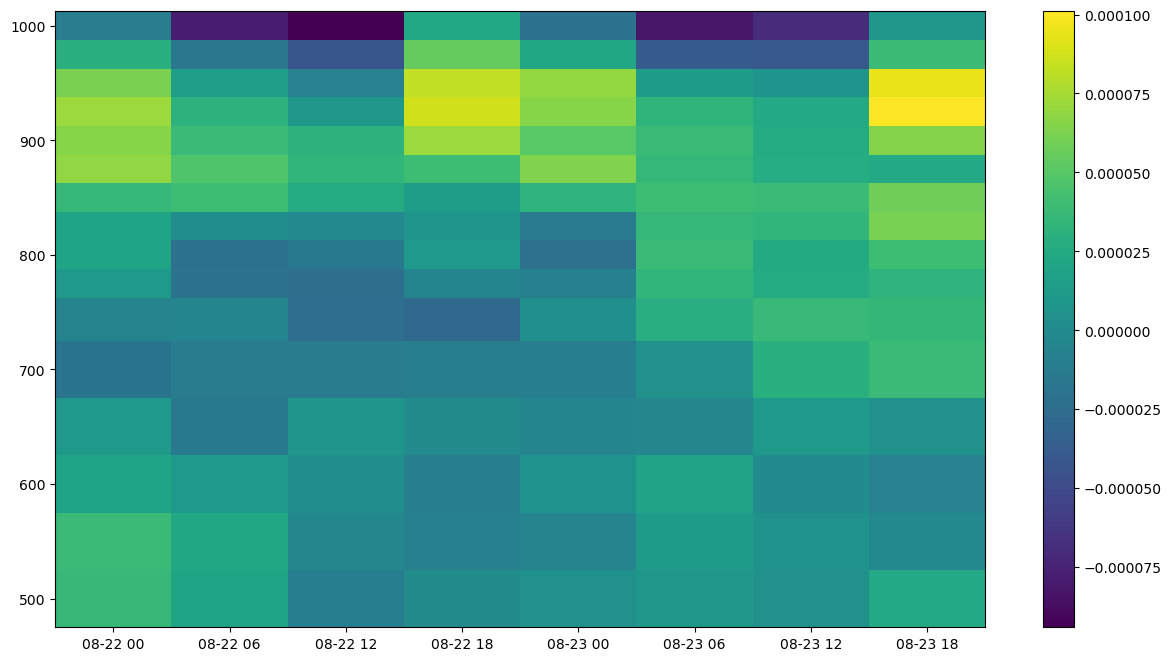

In [3]:
# Berechne die Divergenz als Divergenz des horizontalen Windfeldes in 1000 m höher oder darüber / darunter aus Era5:
# IQQ: -20.539444 ; -70.1772694 (-20.5 ==index 82, -70.25 == index 79)

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import math

###########################################

def haversine(lon1, lat1, lon2, lat2):
    # Radius der Erde in Metern
    R = 6371000  # in Metern
    
    # Koordinaten in Bogenmaß umwandeln
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)
    
    # Haversine-Formel
    a = math.sin(delta_phi / 2) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    # Entfernung berechnen
    distance = R * c  # in Metern
    return distance

################################


era5_file = "/home/qwertz/forcing_icon/era5data_August/pl_q_u_v_201808_6hourly.nc"
ds_era5 = xr.open_dataset(era5_file)

ds_reduced = ds_era5.sel(time=slice("2018-08-22", "2018-08-23")).sel(level=1000)

plt.quiver(ds_reduced.isel(time=0)["longitude"],ds_reduced.isel(time=0)["latitude"],\
           ds_reduced.isel(time=0)["u"],  ds_reduced.isel(time=0)["v"], scale=800.)
plt.xlim(-80,-60)
plt.ylim(-30,-10)

ds_iqq_by_level_and_time = np.zeros([len(ds_era5.sel(time=slice("2018-08-22", "2018-08-23"))["time"]),len(ds_era5["level"])])

for i, level in enumerate(ds_era5["level"]):
    # print(i, level)
    # 1000 m = 15
    ds = ds_era5.sel(time=slice("2018-08-22", "2018-08-23")).isel(level=i)
    
    for j, timestep in enumerate(ds["time"].values):
        lonpl = ds["longitude"].values[80]
        lonmi =  ds["longitude"].values[78]
        latpl = ds["latitude"].values[83]
        latmi = ds["latitude"].values[81]
        ds_iqq_by_level_and_time[j,i] = (ds["u"][j, 82, 80] - ds["u"][j, 82, 78]) / (haversine(lonpl, -20.5 , lonmi, -20.5 )) +\
            (ds["v"][j, 83, 79] - ds["v"][j, 81, 79]) / (haversine(-70.25, latpl , -70.25, latmi))
    
plt.figure(figsize=(15,8))
plt.pcolormesh(ds["time"], ds_era5["level"], ds_iqq_by_level_and_time.T)
plt.colorbar()

print("Mean divergence at 1000 m: ", np.mean(ds_iqq_by_level_and_time[:,15]))
print("For other heights: ")
for i, level in enumerate(ds_era5["level"]):
    print("Mean divergence at ", i ," ", level.values, " m: ", np.mean(ds_iqq_by_level_and_time[:,i]))

# - 7.5e-5 bis 1.e-4

Iquique index:  1273
Iquique distance from cell center:  3.731281889833865
Cells close by:  [1265, 1266, 1267, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 2811, 2817, 2820, 2822]
1265  vlat:  [-0.36151386 -0.3591812  -0.35898692]
1265  vlon:  [-1.22093548 -1.21924078 -1.22262259]
1266  vlat:  [-0.35898692 -0.36132407 -0.36151386]
1266  vlon:  [-1.22262259 -1.22431864 -1.22093548]
1267  vlat:  [-0.36132407 -0.35898692 -0.35881111]
1267  vlon:  [-1.22431864 -1.22262259 -1.22600944]
1272  vlat:  [-0.35412173 -0.35646723 -0.35664776]
1272  vlon:  [-1.22261707 -1.22431284 -1.22092735]
1273  vlat:  [-0.35646723 -0.35881111 -0.35898692]
1273  vlon:  [-1.22431284 -1.22600944 -1.22262259]
1274  vlat:  [-0.35898692 -0.35664776 -0.35646723]
1274  vlon:  [-1.22262259 -1.22092735 -1.22431284]
1275  vlat:  [-0.35664776 -0.35898692 -0.3591812 ]
1275  vlon:  [-1.22092735 -1.22262259 -1.21924078]
1276  vlat:  [-0.35881111 -0.35646723 -0.35630455]
1276  vlon:  [-1.22600944 -1.22431284 -1.22770289]
1277  v

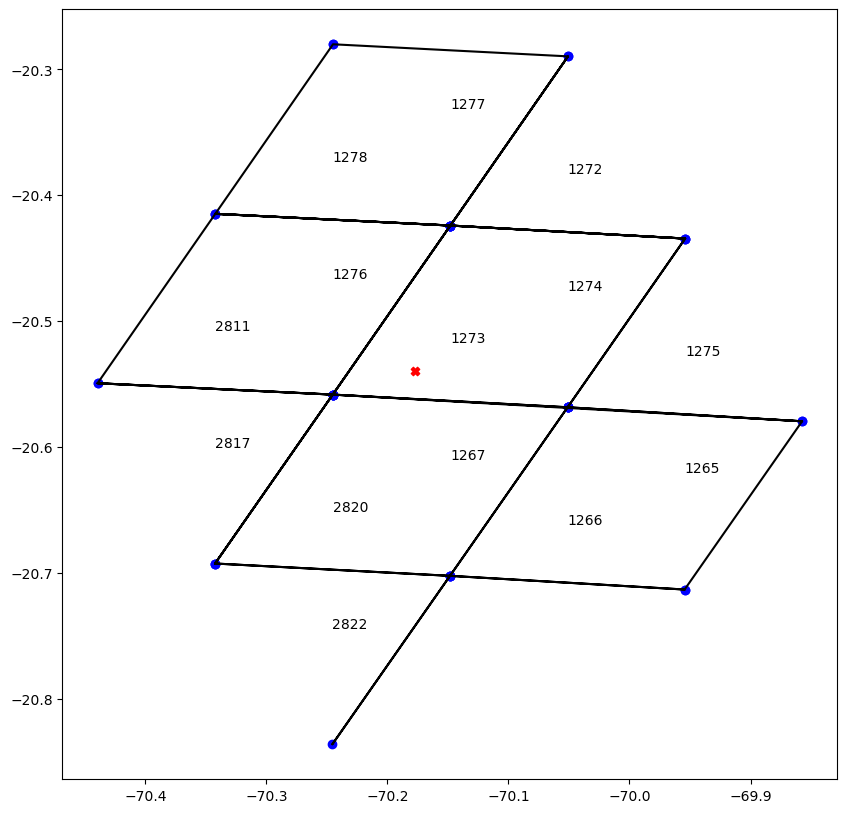

In [25]:
# ICON global:

# HHL 60 == 1062 m
from geopy.distance import geodesic

path_icon = "/home/qwertz/forcing_icon/icon20180822/"
gridfile = "icon_grid_chile_R03B07_20180103.nc"
extpar_file = "icon_extpar_chile_R03B07_20180103.nc"
file = "entpackt/2018/08/2018082200_icon.nc"
datads = xr.open_dataset(path_icon+file)

############################################

path = "/home/qwertz/forcing_icon/icon20180822/"
list_of_files = ["icon_extpar_chile_R03B07_20180103.nc", "icon_grid_chile_R03B07_20180103.nc"]

ds1 = xr.open_dataset(path+list_of_files[0])
ds2 = xr.open_dataset(path+list_of_files[1])
gridds = xr.open_dataset(path_icon+gridfile)

##############################################
# Find grid cell of IQQ:


ref_distance = 300
iqq_index = 0
close = []
for i, (clatval, clonval) in enumerate(zip(gridds["clat"].values, gridds["clon"].values)):
    lat2 = np.rad2deg(clatval)
    lon2 = np.rad2deg(clonval)
    lat1_ref= -20.539444
    lon1_ref= -70.1772694
    reference_point = (lat1_ref, lon1_ref)
    target_point = (lat2, lon2)
    distance = geodesic(reference_point, target_point).kilometers
    if distance < ref_distance:
        ref_distance = distance
        iqq_index = i
    if distance<25:
        close.append(i)

print("Iquique index: ", iqq_index)
print("Iquique distance from cell center: ", ref_distance)
print("Cells close by: ", close)

# Iquique index:  1273
# Iquique distance from cell center:  3.731281889833865
# Cells close by:  [1266, 1267, 1273, 1274, 1276, 1278, 2811, 2817, 2820]
# close = [1267, 1273, 1276]

##############################################
# Find neighbour grid cells:
lons = []
lats = []
plt.figure(figsize=(10,10))
for index in close:
    print(index, " vlat: ", gridds["clat_vertices"].values[index])
    print(index, " vlon: ", gridds["clon_vertices"].values[index])
    mean_lon = np.rad2deg(np.mean(gridds["clon_vertices"].values[index]))
    mean_lat = np.rad2deg(np.mean(gridds["clat_vertices"].values[index]))
    plt.text(mean_lon, mean_lat, str(index))
    for (lat, lon) in zip(gridds["clat_vertices"].values[index], gridds["clon_vertices"].values[index]):
        lons.append(np.rad2deg(lon))
        lats.append(np.rad2deg(lat))

plt.scatter(lons, lats, color="blue")
plt.scatter(-70.1772694, -20.539444, color="red", marker="X")
plt.plot(lons, lats, color="black")
# plt.plot(lons[::2], lats[::2], color="black")

##############################################

div_by_time = np.zeros([len(datads["time"])])
#for i, timestep in enumerate(datads["time"]):
#    div_by_time[i] = (datads["u"][i, 60, ] - datads["u"][i, 60, 78]) / (haversine(lonpl, -20.5 , lonmi, -20.5 )) +\
#            (datads["v"][i, 60, 79] - datads["v"][i, 60, 79]) / (haversine(-70.25, latpl , -70.25, latmi))


# Oh, mein Gott. Wie finde ich nur heraus, welches hier die benachbarten Zellen sind? Willkommen in der Hölle...

#print(datads["HHL"].isel(ncells=0).values)
#print(datads["HHL"].isel(ncells=0).values[60])
#print(datads.data_vars)
#print(datads)

print(ds_grid)